In [ ]:
! pip3 install --upgrade --user --quiet google-cloud-aiplatform

In [ ]:
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
PROJECT_ID = "catherine-project-420117"
LOCATION = "us-central1"

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
from vertexai.generative_models import GenerationConfig, GenerativeModel

In [ ]:
model = GenerativeModel("gemini-1.5-pro")

In [ ]:
generation_config = GenerationConfig(
    temperature=0.9,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

In [ ]:
chat = model.start_chat()

def grade_story(story):
    prompt = f"""Grade the story out of 40 based on:
1. Grammar (10)
2. Coherence (10)
3. Plot (10)
4. Creativity (10)

Provide short comments (1-2 sentences) for each category in the format:
- Grammar: [score], [comment]
- Coherence: [score], [comment]
- Plot: [score], [comment]
- Creativity: [score], [comment]
Overall Score: [score]

Story:\n\n{story.strip()}\n\n"""

    responses = chat.send_message(prompt, stream=True)

    score = ''
    for response in responses:
        score += response.text

    return score.strip()

In [ ]:
def samp_story(textfile):

  with open(textfile, 'r', encoding='utf-8') as file:
    stories = file.read().split('---------------')

  min_word_count = 50
  sampled_stories = []

  for i, story in enumerate(stories):
    word_count = len(story.split())

    if story.strip() and word_count >= min_word_count:
        sampled_stories.append((story))

    if len(sampled_stories) >= 200:
        break

  return sampled_stories

In [ ]:
def grading(stories):
  grades = []

  for i, story in enumerate(stories):
    if story.strip():
      grade = grade_story(story)
      grades.append((i+1, grade))

  return grades

In [ ]:
# def extract_scores(grading_results):
#     extracted_scores = []

#     for _, result in grading_results:
#         # Use regex to match each score
#         grammar_match = re.search(r'\*\*Grammar:\*\*\s*(\d+)/10', result)
#         coherence_match = re.search(r'\*\*Coherence:\*\*\s*(\d+)/10', result)
#         plot_match = re.search(r'\*\*Plot:\*\*\s*(\d+)/10', result)
#         creativity_match = re.search(r'\*\*Creativity:\*\*\s*(\d+)/10', result)
#         overall_match = re.search(r'\*\*Overall Score:\s*(\d+)/40', result)

#         if all([grammar_match, coherence_match, plot_match, creativity_match, overall_match]):
#             scores = {
#                 'Grammar': int(grammar_match.group(1)),
#                 'Coherence': int(coherence_match.group(1)),
#                 'Plot': int(plot_match.group(1)),
#                 'Creativity': int(creativity_match.group(1)),
#                 'Overall': int(overall_match.group(1))
#             }
#             extracted_scores.append(scores)
#         else:
#             print(f"Failed to match scores for the following result: {result[:100]}...")

#     return extracted_scores

In [ ]:
def extract(grades):
    extracted_scores = []

    grammar_pattern = r"Grammar.*?(\d{1,2})/10"
    coherence_pattern = r"Coherence.*?(\d{1,2})/10"
    plot_pattern = r"Plot.*?(\d{1,2})/10"
    creativity_pattern = r"Creativity.*?(\d{1,2})/10"
    overall_pattern = r"Overall Score.*?(\d{1,2})/40"

    for grade in grades:
        grade_text = grade[1]

        scores = {
            'Grammar': None,
            'Coherence': None,
            'Plot': None,
            'Creativity': None,
            'Overall': None
        }

        grammar_match = re.search(grammar_pattern, grade_text)
        coherence_match = re.search(coherence_pattern, grade_text)
        plot_match = re.search(plot_pattern, grade_text)
        creativity_match = re.search(creativity_pattern, grade_text)
        overall_match = re.search(overall_pattern, grade_text)

        if grammar_match:
            scores['Grammar'] = int(grammar_match.group(1))
        if coherence_match:
            scores['Coherence'] = int(coherence_match.group(1))
        if plot_match:
            scores['Plot'] = int(plot_match.group(1))
        if creativity_match:
            scores['Creativity'] = int(creativity_match.group(1))
        if overall_match:
            scores['Overall'] = int(overall_match.group(1))

        if any(scores.values()):
            extracted_scores.append(scores)
        else:
            print(f"Failed to match scores for the following result: {grade_text[:100]}...")  # For debugging

    return extracted_scores

##Scoring ZMax Stories##

In [ ]:
ZMax = samp_story('sample_ZuluMax.txt')
ZMax_grades = grading(ZMax)

ZMax_scores = extract(ZMax_grades)
ZMax_df = pd.DataFrame(ZMax_scores)

In [ ]:
ZMax_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,7,6,5,6,24
1,8,8,6,6,28
2,9,9,7,7,32
3,3,4,2,3,12
4,7,6,5,6,24


##Visualizing ZMax Scores##

In [245]:
average_scores = ZMax_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
ZMax_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [246]:
ZMax_dfnew

,Average Score,Normalized Average Score
Grammar,6.440,0.6440
Coherence,5.120,0.5120
Plot,3.860,0.3860
Creativity,4.475,0.4475


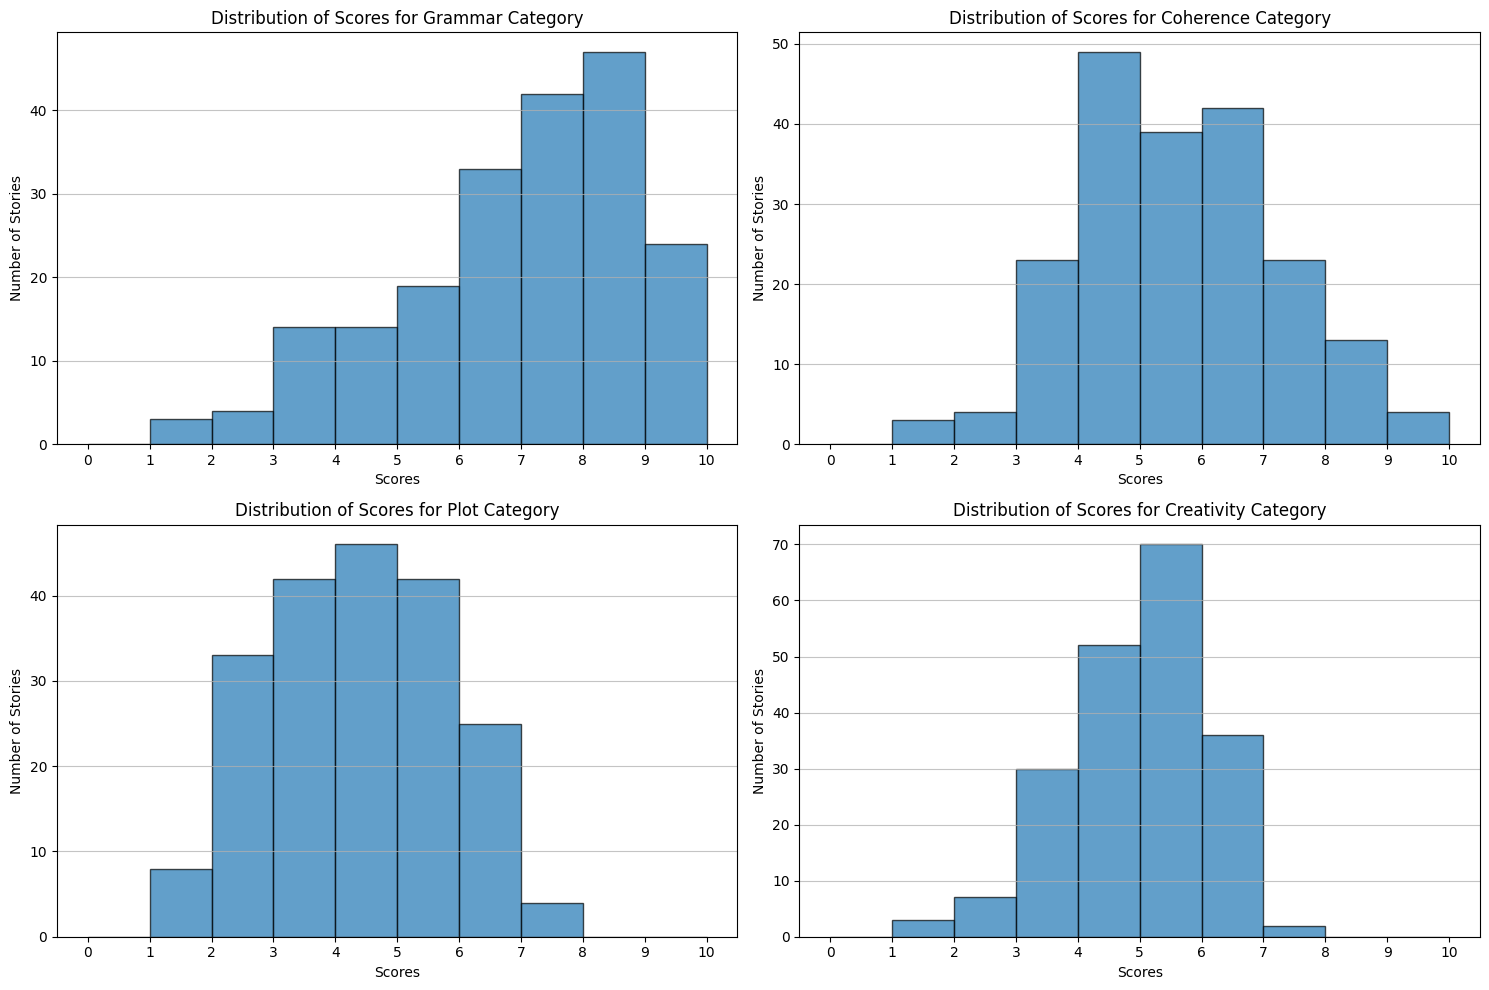

In [244]:
categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(ZMax_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Scores for {category} Category')
    plt.xlabel('Scores')
    plt.ylabel('Number of Stories')
    plt.xticks(range(11))
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('ZMax.pdf', bbox_inches='tight')
plt.show()

##Scoring ZMin Stories##

In [ ]:
ZMin = samp_story('sample_ZuluMini.txt')
ZMin_grades = grading(ZMin)

ZMin_scores = extract(ZMin_grades)
ZMin_df = pd.DataFrame(ZMin_scores)

Failed to match scores for the following result: - **Grammar:** 4/10 The story contains numerous grammatical errors, including sentence fragments, in...


In [ ]:
# new_row = pd.DataFrame({'Grammar': [4], 'Coherence': [3], 'Plot': [2], 'Creativity': [4], 'Overall': [13]}, index=[176])
# ZMin_df = pd.concat([ZMin_df.iloc[:186], new_row, ZMin_df.iloc[186:]]).reset_index(drop=True)

In [ ]:
ZMin_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,7,6,4,4,21
1,6,4,3,4,17
2,4,3,2,4,13
3,4,3,2,3,12
4,2,2,1,2,7


##Visualising ZMin Scores##

In [242]:
average_scores = ZMin_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
ZMin_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [243]:
ZMin_dfnew

,Average Score,Normalized Average Score
Grammar,4.615,0.4615
Coherence,3.475,0.3475
Plot,2.495,0.2495
Creativity,3.955,0.3955


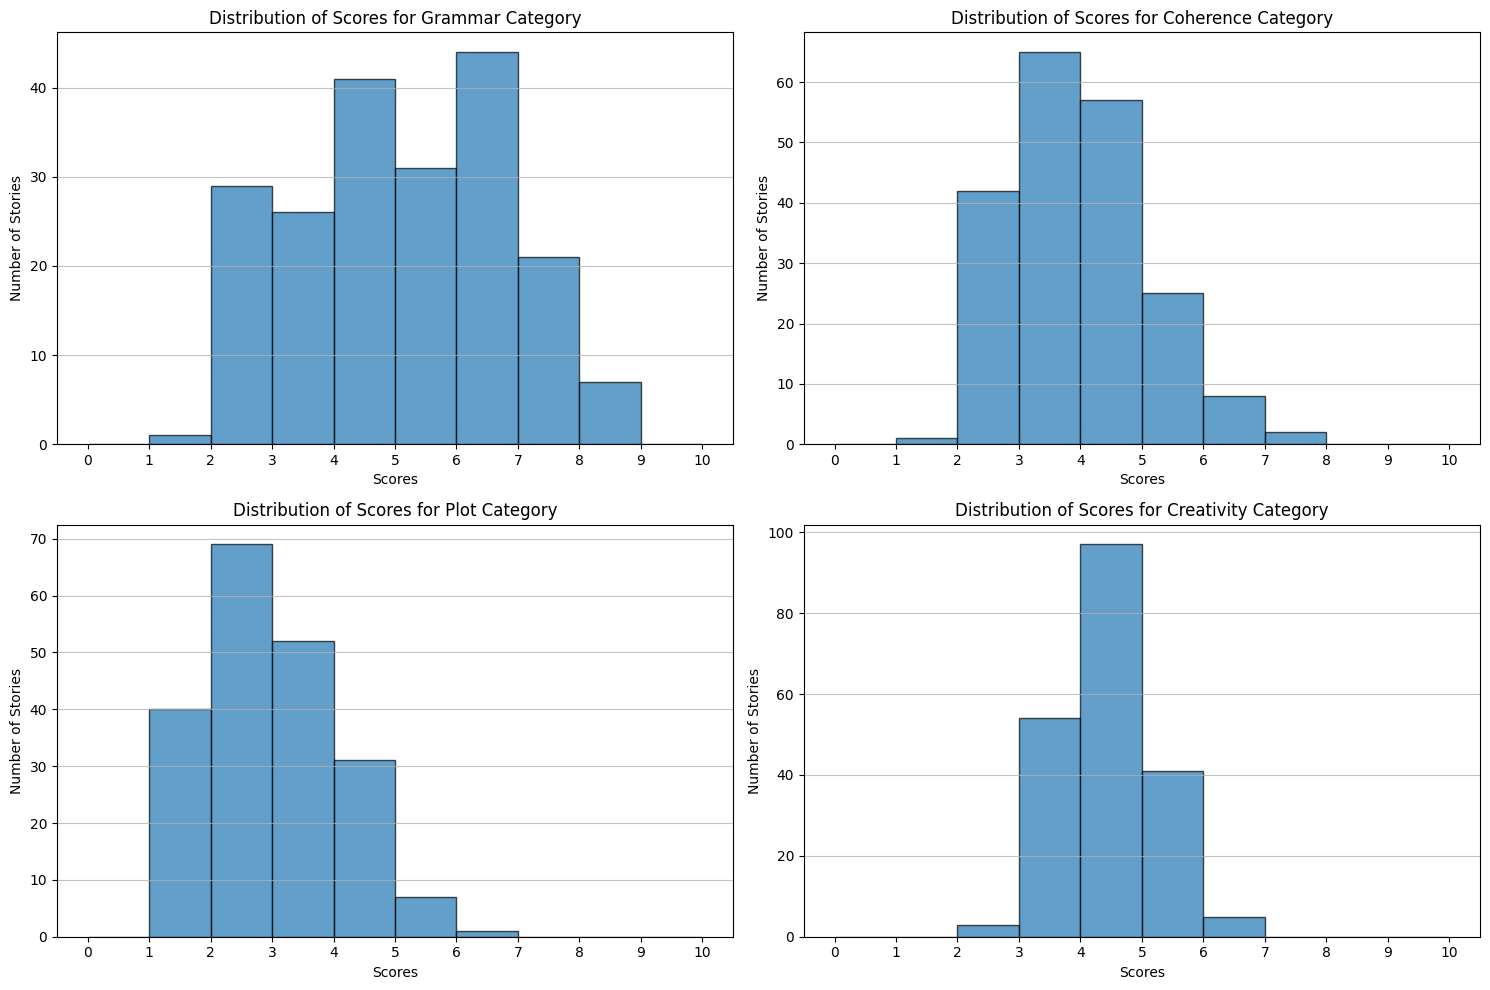

In [241]:
categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(ZMin_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Scores for {category} Category')
    plt.xlabel('Scores')
    plt.ylabel('Number of Stories')
    plt.xticks(range(11))
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('ZMin.pdf', bbox_inches='tight')
plt.show()

##Scoring ZPrompt Stories##

In [ ]:
ZPrompt = samp_story('sample_ZuluPrompt.txt')
ZPrompt_grades = grading(ZPrompt)
ZPrompt_scores = extract(ZPrompt_grades)
ZPrompt_df = pd.DataFrame(ZPrompt_scores)

In [ ]:
ZPrompt_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,8,5,4,6,23
1,7,6,6,6,25
2,7,4,4,6,21
3,7,5,5,5,22
4,6,5,4,7,22


##Visualising ZPrompt Scores##

In [239]:
average_scores = ZPrompt_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
ZPrompt_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [240]:
ZPrompt_dfnew

,Average Score,Normalized Average Score
Grammar,6.830,0.6830
Coherence,4.925,0.4925
Plot,4.020,0.4020
Creativity,5.490,0.5490


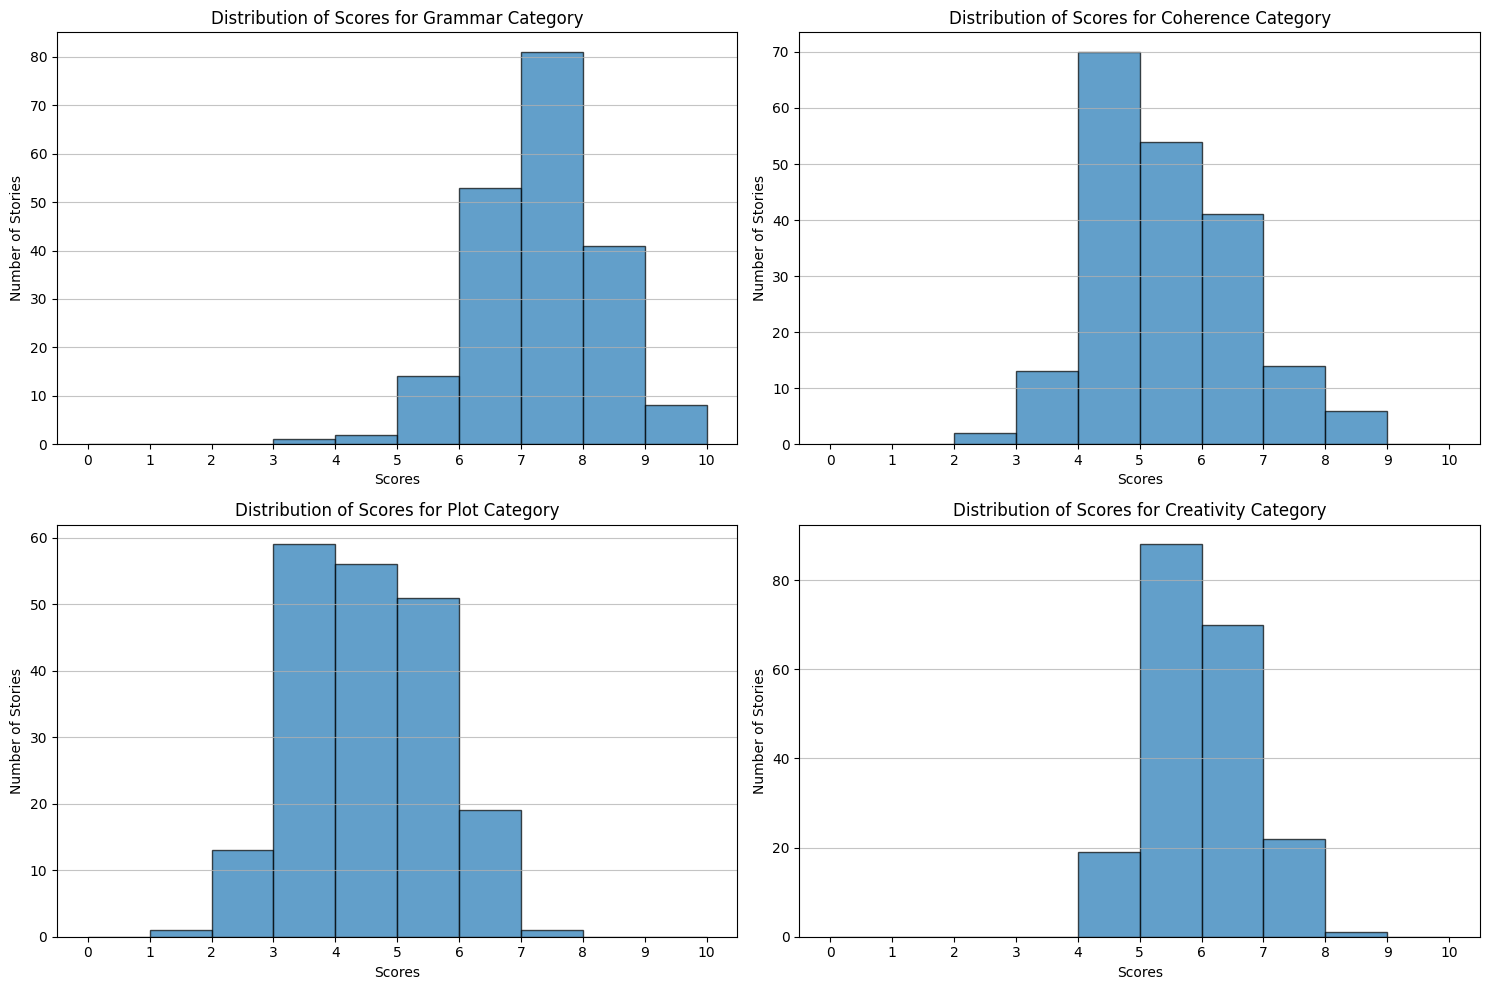

In [238]:
categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(ZPrompt_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Scores for {category} Category')
    plt.xlabel('Scores')
    plt.ylabel('Number of Stories')
    plt.xticks(range(11))
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('ZPrompt.pdf', bbox_inches='tight')
plt.show()

##Scoring YMax Stories##

In [ ]:
YMax = samp_story('sample_YorubaMax.txt')
YMax_grades = grading(YMax)
YMax_scores = extract(YMax_grades)
YMax_df = pd.DataFrame(YMax_scores)

In [ ]:
YMax_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,NaN,NaN,6,5,NaN
1,7.0,8.0,6,6,NaN
2,7.0,8.0,6,7,NaN
3,8.0,9.0,6,7,NaN
4,9.0,7.0,5,6,NaN


##Visualising YMax Scores##

In [ ]:
average_scores = YMax_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
YMax_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [ ]:
YMax_dfnew

,Average Score,Normalized Average Score
Grammar,7.19598,0.719598
Coherence,5.41206,0.541206
Plot,4.18500,0.418500
Creativity,5.15500,0.515500


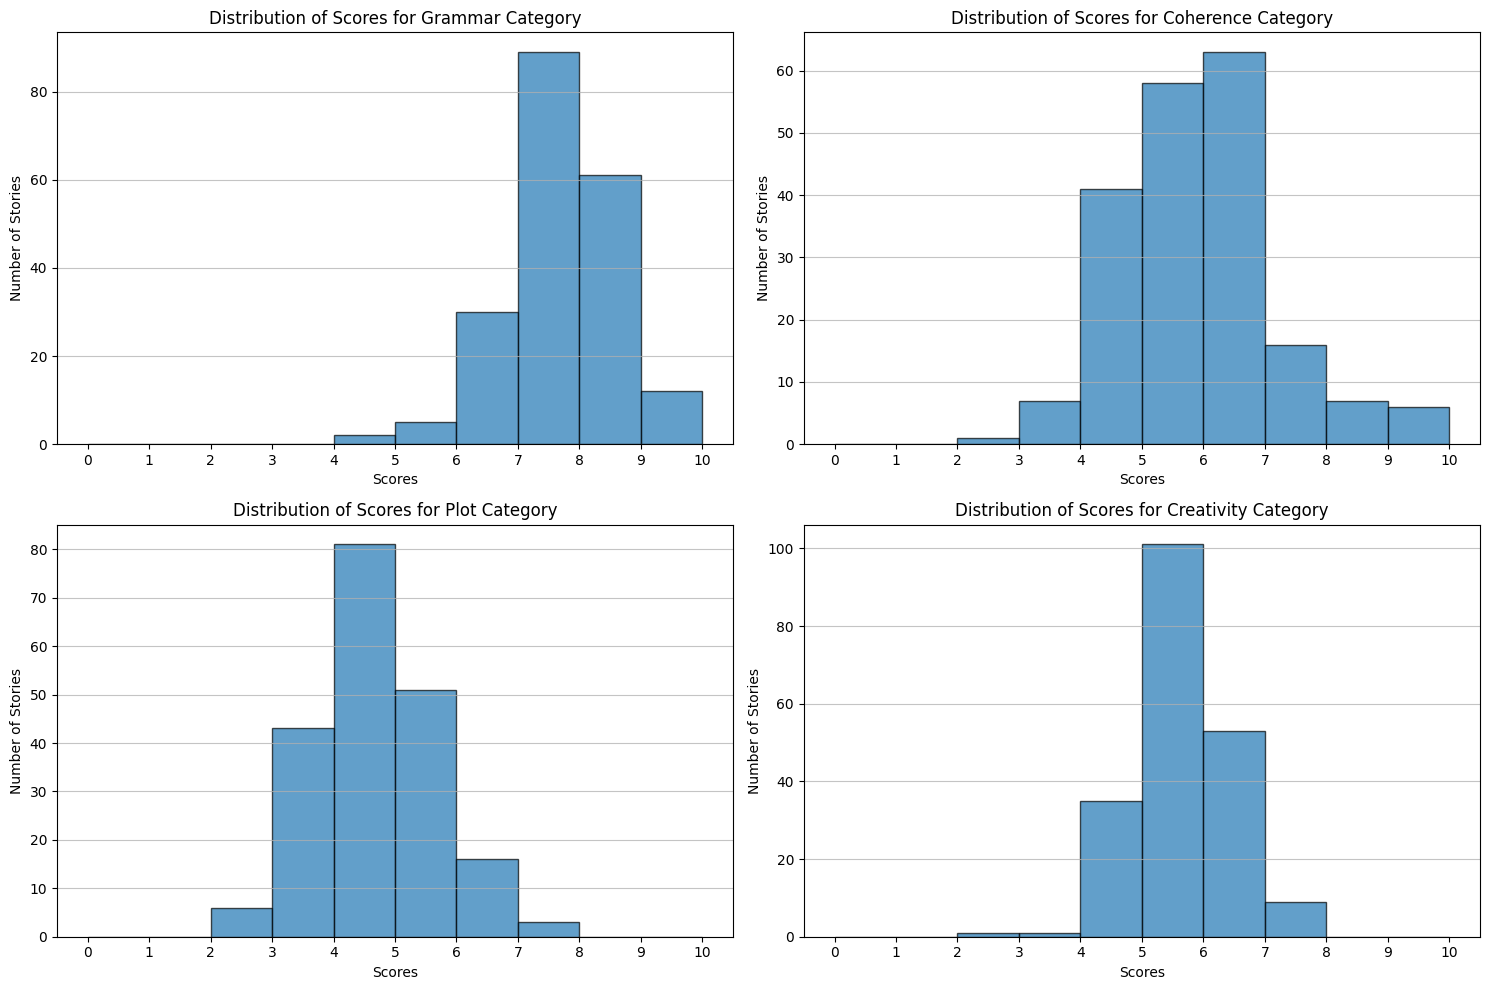

In [ ]:
categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(YMax_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Scores for {category} Category')
    plt.xlabel('Scores')
    plt.ylabel('Number of Stories')
    plt.xticks(range(11))
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('YMax.pdf', bbox_inches='tight')
plt.show()

##Scoring YMini Stories##


In [ ]:
YMini = samp_story('sample_YorubaMini.txt')
YMini_grades = grading(YMini)
YMini_scores = extract(YMini_grades)
YMini_df = pd.DataFrame(YMini_scores)

In [ ]:
YMini_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,8,8,6,6,28
1,9,6,5,6,26
2,9,8,6,6,29
3,8,7,6,6,27
4,7,6,4,5,22


##Visualising YMini Scores##

In [ ]:
average_scores = YMini_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
YMini_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [ ]:
YMini_dfnew

,Average Score,Normalized Average Score
Grammar,6.865,0.6865
Coherence,5.195,0.5195
Plot,4.070,0.4070
Creativity,4.910,0.4910


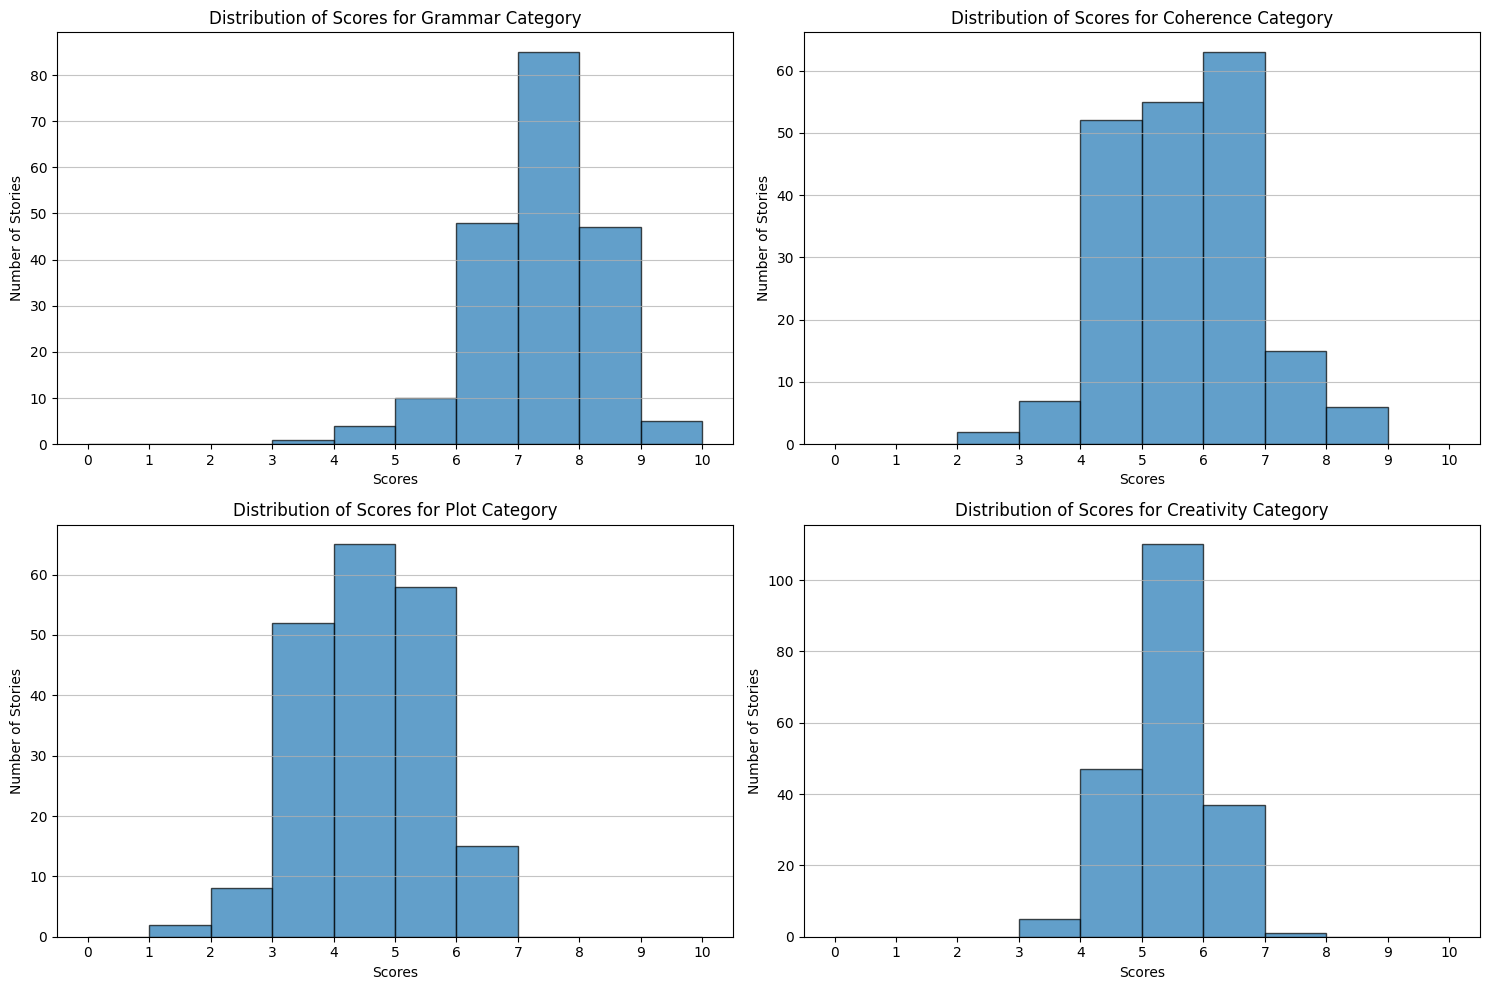

In [ ]:
categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(YMini_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Scores for {category} Category')
    plt.xlabel('Scores')
    plt.ylabel('Number of Stories')
    plt.xticks(range(11))
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('YMini.pdf', bbox_inches='tight')
plt.show()

##Scoring YPrompt Stories##

In [ ]:
YPrompt = samp_story('sample_YorubaPrompt.txt')
YPrompt_grades = grading(YPrompt)
YPrompt_scores = extract(YPrompt_grades)
YPrompt_df = pd.DataFrame(YPrompt_scores)

In [ ]:
YPrompt_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,7,8,6,8,29
1,8,6,4,6,24
2,8,9,5,6,28
3,8,6,5,6,25
4,9,9,6,7,31


##Visualizing YPrompt Scores##

In [ ]:
average_scores = YPrompt_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
YPrompt_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [ ]:
YPrompt_dfnew

,Average Score,Normalized Average Score
Grammar,7.475,0.7475
Coherence,5.340,0.5340
Plot,4.170,0.4170
Creativity,5.890,0.5890


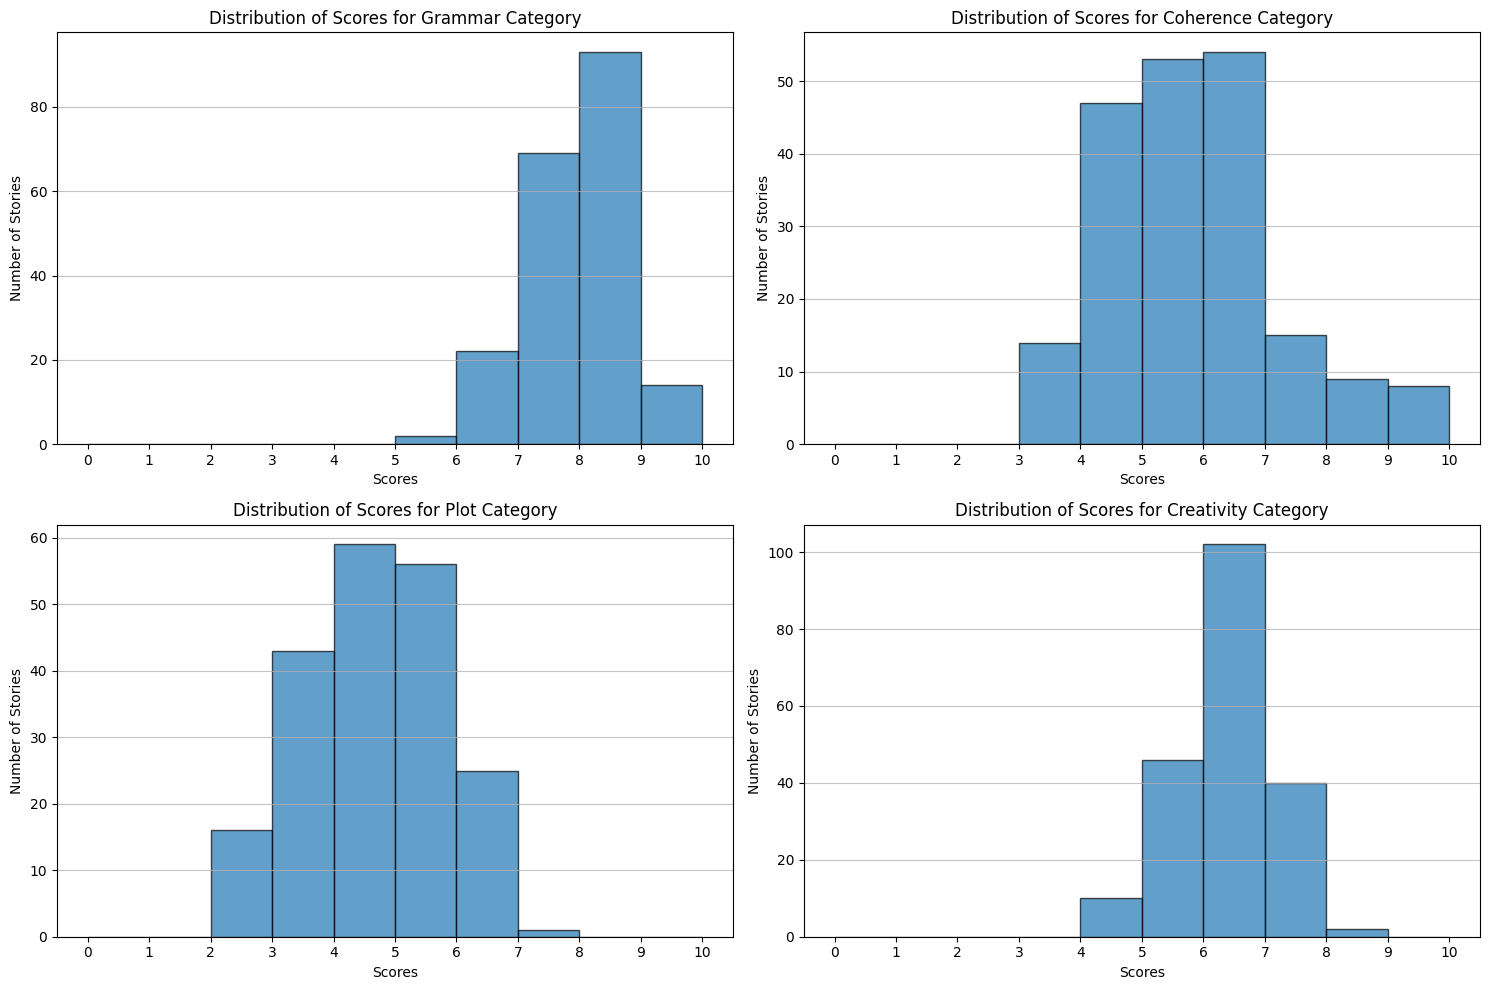

In [ ]:
categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(YPrompt_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Scores for {category} Category')
    plt.xlabel('Scores')
    plt.ylabel('Number of Stories')
    plt.xticks(range(11))
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('YPrompt.pdf', bbox_inches='tight')
plt.show()